In [1]:
import numpy as np
import pandas as pd
import random

class PricingEnv:
    def __init__(self, df_route):
        """
        Initialize environment for one route's data.
        """
        self.df = df_route.sort_values("time_index").reset_index(drop=True)
        self.current_step = 0
        
        # Define action space (price changes)
        self.actions = [-0.10, -0.05, 0, 0.05, 0.10]
        
        # State columns
        self.state_cols = ["demand_index", "quarter_sin", "quarter_cos", "fare_diff", "large_ms"]
        
    def reset(self):
        """Start new episode"""
        self.current_step = 0
        return self.df.loc[self.current_step, self.state_cols].values
    
    def step(self, action_idx):
        """
        Take an action (adjust price) and return new state, reward, done flag.
        """
        # Get current data
        row = self.df.loc[self.current_step]
        fare = row["fare"]
        passengers = row["passengers"]
        
        # Action = price change %
        action = self.actions[action_idx]
        new_fare = fare * (1 + action)
        
        # Simulate demand change (basic elasticity)
        # if price increases, passengers drop slightly
        elasticity = -0.8  # example elasticity
        new_passengers = passengers * (1 + elasticity * action)
        
        # Reward = Revenue = price * passengers
        reward = new_fare * new_passengers
        
        # Next step
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        
        if not done:
            next_state = self.df.loc[self.current_step, self.state_cols].values
        else:
            next_state = np.zeros(len(self.state_cols))
        
        return next_state, reward, done


In [2]:
# Load your processed routes
df = pd.read_csv("processed_routes.csv")

# Pick one route
route_df = df[df["route"] == df["route"].unique()[0]]

env = PricingEnv(route_df)

state = env.reset()
print("Initial state:", state)

for t in range(5):
    action = random.randint(0, 4)
    next_state, reward, done = env.step(action)
    print(f"Step {t+1}: Action={env.actions[action]}, Reward={reward:.3f}")
    if done:
        break


Initial state: [0.863796134 1.0 6.12e-17 0.369741502 0.32]
Step 1: Action=0, Reward=0.101
Step 2: Action=0, Reward=0.075
Step 3: Action=-0.05, Reward=0.080
Step 4: Action=-0.1, Reward=0.081
Step 5: Action=-0.05, Reward=0.068


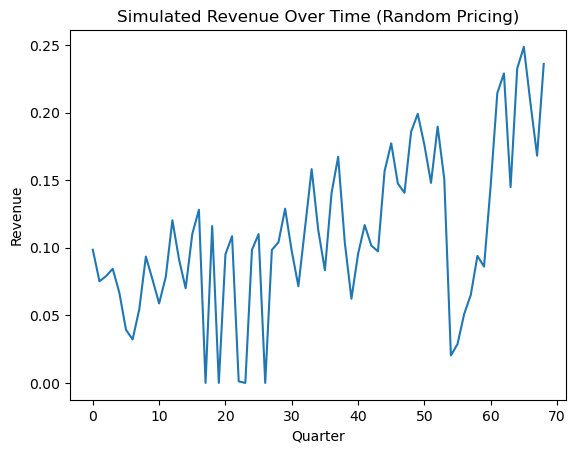

In [3]:
import matplotlib.pyplot as plt

rewards = []
env.reset()
for i in range(len(route_df)-1):
    action = random.randint(0, 4)
    _, reward, done = env.step(action)
    rewards.append(reward)
    if done:
        break

plt.plot(rewards)
plt.title("Simulated Revenue Over Time (Random Pricing)")
plt.xlabel("Quarter")
plt.ylabel("Revenue")
plt.show()


In [12]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ Load Data (Boston → Miami)
# -------------------------------
df = pd.read_csv("processed_routes.csv")

route_df = df[
    (df["city1"].str.contains("Boston", case=False, na=False)) &
    (df["city2"].str.contains("San", case=False, na=False))
].sort_values(["Year", "quarter"]).reset_index(drop=True)

print("Selected route:", route_df.iloc[0]["city1"], "→", route_df.iloc[0]["city2"])
print("Total quarters:", len(route_df))

Selected route: Boston, MA (Metropolitan Area) → San Francisco, CA (Metropolitan Area)
Total quarters: 1062


In [13]:
# -------------------------------
# 2️⃣ Define RL Environment
# -------------------------------
class PricingEnv:
    def __init__(self, route_df):
        self.data = route_df.reset_index(drop=True)
        self.ptr = 0
        self.actions = [-0.1, -0.05, 0, 0.05, 0.1]  # % change in fare
        self.base_fare = self.data.loc[0, "fare"]
        self.base_passengers = self.data.loc[0, "passengers"]

    def reset(self):
        self.ptr = 0
        self.current_fare = self.data.loc[self.ptr, "fare"]
        self.current_demand = self.data.loc[self.ptr, "passengers"]
        return self.current_fare, self.current_demand

    def step(self, action_idx):
        action = self.actions[action_idx]
        next_ptr = self.ptr + 1

        # Stop when data ends
        if next_ptr >= len(self.data):
            return (self.current_fare, self.current_demand), 0, True

        # Adjust fare based on action
        new_fare = self.current_fare * (1 + action)

        # Simulate demand elasticity (if fare ↑ → passengers ↓)
        price_elasticity = -0.6
        new_demand = max(
            0,
            self.current_demand * (1 + price_elasticity * action)
            + np.random.normal(0, self.current_demand * 0.05)  # random noise
        )

        # Reward = Revenue = Price × Demand
        reward = new_fare * new_demand / 1e6  # scaled

        # Update state
        self.ptr = next_ptr
        self.current_fare = new_fare
        self.current_demand = new_demand

        done = next_ptr >= len(self.data) - 1
        return (self.current_fare, self.current_demand), reward, done

In [3]:
# -------------------------------
# 2️⃣ Environment class
# -------------------------------
class FlightPricingEnv:
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.idx = 0
        self.current_fare = self.df.loc[self.idx, "fare"]
        self.current_demand = self.df.loc[self.idx, "passengers"]

    def reset(self):
        self.idx = 0
        self.current_fare = self.df.loc[self.idx, "fare"]
        self.current_demand = self.df.loc[self.idx, "passengers"]
        return self.current_fare, self.current_demand

    def step(self, action):
        # Define actions as price multipliers
        price_change = {0: 0.9, 1: 0.95, 2: 1.0, 3: 1.05, 4: 1.1}[action]
        self.current_fare *= price_change

        # Simulate demand response (inverse relation with price)
        demand_sensitivity = -0.3 * (price_change - 1)  # if price ↑, demand ↓
        self.current_demand = max(100, self.current_demand * (1 + demand_sensitivity + np.random.uniform(-0.05, 0.05)))

        # Reward = revenue
        reward = self.current_fare * self.current_demand / 1e6  # scaled

        self.idx += 1
        done = self.idx >= len(self.df) - 1
        return (self.current_fare, self.current_demand), reward, done


In [14]:
# -------------------------------
# 3️⃣ State Discretization
# -------------------------------
def get_state(fare, demand, route_df):
    # Discretize into 10 bins
    fare_bins = np.linspace(route_df["fare"].min(), route_df["fare"].max(), 10)
    demand_bins = np.linspace(route_df["passengers"].min(), route_df["passengers"].max(), 10)
    fare_idx = np.digitize(fare, fare_bins) - 1
    demand_idx = np.digitize(demand, demand_bins) - 1
    return (fare_idx, demand_idx)

In [15]:
# -------------------------------
# 4️⃣ Initialize Q-table & Params
# -------------------------------
num_actions = 5
Q = np.zeros((10, 10, num_actions))

alpha = 0.1      # learning rate
gamma = 0.9      # discount factor
epsilon = 0.2    # exploration rate

env = PricingEnv(route_df)

In [16]:
# -------------------------------
# 5️⃣ Train Q-Learning Agent
# -------------------------------
episodes = 300
rewards_per_ep = []

for ep in range(episodes):
    state_vals = env.reset()
    state = get_state(state_vals[0], state_vals[1], route_df)
    total_reward = 0

    for _ in range(len(route_df) - 1):
        # ε-greedy strategy
        if random.random() < epsilon:
            action = random.randint(0, num_actions - 1)
        else:
            action = np.argmax(Q[state])

        next_state_vals, reward, done = env.step(action)
        next_state = get_state(next_state_vals[0], next_state_vals[1], route_df)

        # Q-update rule
        Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])

        total_reward += reward
        state = next_state

        if done:
            break

    rewards_per_ep.append(total_reward)

    if ep % 50 == 0:
        print(f"Episode {ep} — Total Reward: {total_reward:.3f}")

Episode 0 — Total Reward: 0.000
Episode 50 — Total Reward: 0.000
Episode 100 — Total Reward: 0.000
Episode 150 — Total Reward: 0.000
Episode 200 — Total Reward: 0.000
Episode 250 — Total Reward: 0.000


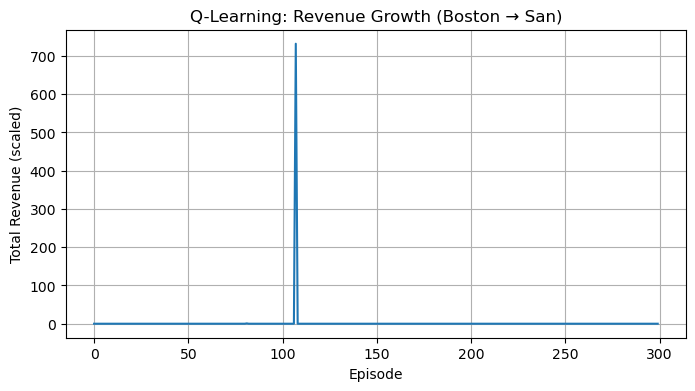

In [18]:
# -------------------------------
# 6️⃣ Plot Learning Curve
# -------------------------------
plt.figure(figsize=(8,4))
plt.plot(rewards_per_ep)
plt.title("Q-Learning: Revenue Growth (Boston → San)")
plt.xlabel("Episode")
plt.ylabel("Total Revenue (scaled)")
plt.grid(True)
plt.show()

In [1]:
import pandas as pd

df = pd.read_csv("processed_routes.csv")


In [9]:
route_df = df[
    (df["city1"].str.contains("Boston", case=False, na=False)) &
    (df["city2"].str.contains("San", case=False, na=False))
].sort_values(["Year", "quarter"]).reset_index(drop=True)

print("Rows found:", len(route_df))
print(route_df[["Year", "quarter", "fare", "passengers"]].head(50))


Rows found: 1062
    Year  quarter      fare  passengers
0   1993        1  0.708776    0.297891
1   1993        1  0.772274    0.000293
2   1993        1  0.761473    0.007323
3   1993        1  0.825066    0.081429
4   1993        1  0.777294    0.004394
5   1993        1  0.991435    0.003808
6   1993        1  0.697952    0.014060
7   1993        1  0.580449    0.001172
8   1993        1  0.601075    0.016403
9   1993        2  0.625984    0.118043
10  1993        2  0.530940    0.008787
11  1993        2  0.484405    0.018161
12  1993        2  0.573906    0.005565
13  1993        2  0.504984    0.494142
14  1993        2  0.513834    0.022261
15  1993        2  0.362144    0.000586
16  1993        2  0.611044    0.002343
17  1993        2  0.793210    0.002929
18  1993        3  0.514477    0.494142
19  1993        3  0.616230    0.106327
20  1993        3  0.438037    0.003808
21  1993        3  0.639545    0.011716
22  1993        3  0.537697    0.005272
23  1993        3  0.57

In [10]:
unique_quarters = route_df["quarter"].nunique()
years_covered = route_df["Year"].nunique()
print("Unique quarters:", unique_quarters)
print("Years covered:", years_covered)


Unique quarters: 4
Years covered: 31
